### Student Information
Name: 留筠雅

Student ID:711233112

GitHub ID:sue6609

Kaggle name:liu yun ya

Kaggle private scoreboard snapshot:  
![snapshot](\img\pic0.PNG)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook.


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking:
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained.















4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__.

## 1. Load data

Due to hardware limitations, I have decided to use Colab to process the data.

In [1]:
# Import the drive module from the Google Colab package
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data
import pandas as pd

#匯入json檔案
df = pd.read_json('tweets_DM.json', lines=True)


In [ ]:
df.head()

,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets


We can see that the "_source" contains tweet data. The goal is to extract this data and split the tweet information into new variables, storing them in a dataframe.

In [ ]:
df_id = pd.read_csv('data_identification.csv') #匯入data_identification.csv，用來分train和test
df_emo = pd.read_csv('emotion.csv') # 匯入emotion.csv，這是target variable

df_new = pd.json_normalize(df['_source']) # 將json檔案中的_source欄位展開
df_new = pd.concat([df.drop(columns=['_source']), df_new], axis=1) # 將展開後的資料和原本的資料合併

# 重新命名欄位
df_new = df_new.rename(columns={"tweet.hashtags": "hashtags",'tweet.tweet_id': 'tweet_id', 'tweet.text': 'text'})
# 用tweet_id合併data_identification.csv和emotion.csv
df_new = pd.merge(df_new, df_id, on='tweet_id', how='left')
df_new = pd.merge(df_new, df_emo, on='tweet_id', how='left')

#分成train和test
df_train = df_new[df_new['identification'] == 'train']
df_test = df_new[df_new['identification'] == 'test']
df_train.head()

,_score,_index,_crawldate,_type,hashtags,tweet_id,text,identification,emotion
0,391,hashtag_tweets,2015-05-23 11:42:47,tweets,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,433,hashtag_tweets,2016-01-28 04:52:09,tweets,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
3,376,hashtag_tweets,2016-01-24 23:53:05,tweets,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
5,120,hashtag_tweets,2015-06-11 04:44:05,tweets,"[authentic, LaughOutLoud]",0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,train,joy
6,1021,hashtag_tweets,2015-08-18 02:30:07,tweets,[],0x2c91a8,Still waiting on those supplies Liscus. <LH>,train,anticipation


Next, save the formatted data.

In [ ]:
## save to pickle file
df_train.to_pickle("df_train.pkl")
df_test.to_pickle("df_test.pkl")

In [2]:
import pandas as pd
df_train = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/DM2024-Lab2-Homework-main/df_train.pkl")
df_test = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/DM2024-Lab2-Homework-main/df_test.pkl")

## 2. Preprocessing

In [ ]:
# Observe the number of data entries
print(len(df_train))
print(len(df_test))

1455563
411972


In [ ]:
df_train["emotion"].value_counts(dropna=False) # 關於情緒的分佈

,count
emotion,
joy,516017
anticipation,248935
trust,205478
sadness,193437
disgust,139101
fear,63999
surprise,48729
anger,39867


Plotting the Bar Chart

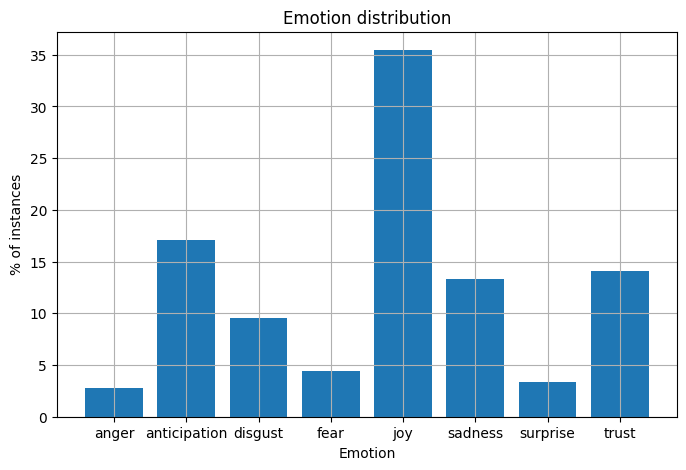

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = df_train['emotion'].unique()
post_total = len(df_train)
df1 = df_train.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(8,5))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

# This is an imbalanced dataset, with "joy" accounting for the majority.

In [ ]:
 # delete <LH>
df_train['text'] = df_train['text'].str.replace('<LH>', '')

In [ ]:
# shuffle dataset
df_train.sample(frac=1)
df_test.sample(frac=1)

,_score,_index,_crawldate,_type,hashtags,tweet_id,text,identification,emotion
875178,97,hashtag_tweets,2015-07-06 02:06:09,tweets,[],0x244f39,@AdamSchefter W actually. Must suck living in ...,test,NaN
295820,445,hashtag_tweets,2017-09-07 12:41:26,tweets,[],0x29145a,Coming up on ‘second thanksgiving’ which means...,test,NaN
499775,972,hashtag_tweets,2017-07-25 04:05:27,tweets,[],0x37d7c1,Now that he's seen we're ~weird~ he has put on...,test,NaN
1464098,942,hashtag_tweets,2015-02-03 01:34:23,tweets,[World],0x2fa14e,"""today is the cup of the Lord’s faithfulness. ...",test,NaN
1028142,988,hashtag_tweets,2017-05-18 16:16:32,tweets,[],0x384287,@MiddleEastEye Saudis using Hajj as a mint fac...,test,NaN
...,...,...,...,...,...,...,...,...,...
1392448,468,hashtag_tweets,2015-11-25 06:27:43,tweets,[],0x2f89f6,All I do is win. Tested. I'm stronger. Nothin...,test,NaN
1096877,134,hashtag_tweets,2016-09-28 16:11:29,tweets,[YouthLifters],0x341498,"I will be glad and rejoice in your love, for y...",test,NaN
1731074,612,hashtag_tweets,2017-03-04 12:21:49,tweets,[Bolt],0x299270,Gutted for Bolt 😱Looking forward to debating i...,test,NaN
1846278,835,hashtag_tweets,2017-04-19 13:55:17,tweets,[],0x2495b2,My little brother is 17 today and still hasn't...,test,NaN


In [ ]:
# split dataset to features and target
X_train = df_train.drop("emotion",axis=1)
y_train = df_train["emotion"]


## 3. Feature Engineering (tensorflow tokenizer)

Import the Tokenizer to convert text into numerical sequences, retaining the top 10,000 most frequent words from all tweet data and using an empty string to represent unknown words.

In [ ]:

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token="")
tokenizer.fit_on_texts(X_train['text'])


Keras only accepts sequences of equal length as input. When our dataset contains sequences of varying lengths, we can use the `pad_sequences()` function to transform them into new sequences of the same length by padding.  
maxlen: The maximum length for the sequences. Sequences longer than this length will be truncated, and those shorter will be padded with zeros at the end.  
padding: 'pre' or 'post', specifies whether to pad zeros at the beginning or the end of the sequence when padding is required.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert the text in the training dataset into sequences of numbers
X_train_sequences = tokenizer.texts_to_sequences(X_train['text'])

# Find the maximum sequence length in the training dataset to define a fixed length for padding
maxlen = max(map(len, X_train_sequences))

# Convert the text in the test dataset into sequences of numbers
X_test_sequences = tokenizer.texts_to_sequences(df_test['text'])

# Pad or truncate the training dataset sequences to the same length
X_train_padded = pad_sequences(X_train_sequences,
                 truncating='post',
                 maxlen=maxlen,
                 padding='post')

# Pad or truncate the test dataset sequences to the same length
X_test_padded = pad_sequences(X_test_sequences,
                maxlen=maxlen,
                padding='post')     # Add padding zeros at the end of sequences




In [ ]:
print(maxlen) # The longest sentence has 43 words.

43


Convert labels `y_train` into numerical encoding.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert labels to numerical encoding
y_train_encoded = label_encoder.fit_transform(y_train)

# Print the first 5 numerical encoded results
print("Label Encoded y_train (first 5 rows):")
print(y_train_encoded[:5])

# Print the first 5 original label values
print("Original y_train (first 5 rows):")
print(y_train[:5])

print(y_train_encoded.shape)


Label Encoded y_train (first 5 rows):
[1 5 3 4 1]
Original y_train (first 5 rows):
0    anticipation
1         sadness
3            fear
5             joy
6    anticipation
Name: emotion, dtype: object
(1455563,)


## 4. Model Training (LSTM)

LSTM is a specialized type of Recurrent Neural Network (RNN) designed to process sequential data and address the long-term dependency issues of traditional RNNs. I plan to use LSTM on this large dataset because tweets have sequential characteristics, with syntactic and semantic relationships between preceding and following words. I hope LSTM can capture contextual associations and enhance predictive performance.



### The model structure:
- The most frequent used words in the data have a dimension of 10,000, and the output input_length of the next layer has a dimension of 50.
- LSTM is bidirectional, during training, this helps to retain past and future results, they are 64, 32 units respectively, each unit has its own input, output and memory.
- Next, connect a fully connected layer, with dimension 16, and the activation function is "relu".
- The last layer has 8 dimensions, so it will return the probability distribution of each emotion in the tweet.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense


model = Sequential([
    Embedding(input_dim=10000, output_dim=50),  # Embedding layer with 10,000 words in vocabulary and 50-dimensional embeddings
    Bidirectional(LSTM(units=64, return_sequences=True)),  # First LSTM layer, returning sequences for the next layer
    Bidirectional(LSTM(units=32)),  # Second LSTM layer
    Dense(units=16, activation='relu'),  # Fully connected layer with 16 units and ReLU activation
    Dense(units=8, activation='softmax')  # Output layer with 8 units and softmax activation
])


model.compile(
    loss='sparse_categorical_crossentropy',  # Loss function
    optimizer='rmsprop',  # RMSprop optimizer
    metrics=['accuracy']  # Metrics to track during training
)

# Print the model summary
model.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Check if there are available GPUs and display all available GPU devices.

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Training

There are a total of 10 epochs, meaning the entire training process will run 10 times. The batch size is 64, and 20% of the data is used as validation data.

In [ ]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('training_log.csv') # Placement accuracy and loss

# Place tensors on the CPU
with tf.device('/CPU:0'):
  h = model.fit(
    X_train_padded, y_train_encoded,
    epochs=10,
    validation_split=0.2,
    callbacks=[csv_logger],
    batch_size=64,
    verbose=1)

Epoch 1/10
18195/18195 ━━━━━━━━━━━━━━━━━━━━ 522s 28ms/step - accuracy: 0.4836 - loss: 1.4345 - val_accuracy: 0.5488 - val_loss: 1.2648
Epoch 2/10
18195/18195 ━━━━━━━━━━━━━━━━━━━━ 547s 28ms/step - accuracy: 0.5559 - loss: 1.2475 - val_accuracy: 0.5583 - val_loss: 1.2393
Epoch 3/10
18195/18195 ━━━━━━━━━━━━━━━━━━━━ 568s 28ms/step - accuracy: 0.5693 - loss: 1.2100 - val_accuracy: 0.5653 - val_loss: 1.2187
Epoch 4/10
18195/18195 ━━━━━━━━━━━━━━━━━━━━ 520s 29ms/step - accuracy: 0.5761 - loss: 1.1936 - val_accuracy: 0.5680 - val_loss: 1.2267
Epoch 5/10
18195/18195 ━━━━━━━━━━━━━━━━━━━━ 580s 30ms/step - accuracy: 0.5814 - loss: 1.1802 - val_accuracy: 0.5689 - val_loss: 1.2146
Epoch 6/10
18195/18195 ━━━━━━━━━━━━━━━━━━━━ 514s 28ms/step - accuracy: 0.5855 - loss: 1.1685 - val_accuracy: 0.5688 - val_loss: 1.2096
Epoch 7/10
18195/18195 ━━━━━━━━━━━━━━━━━━━━ 522s 29ms/step - accuracy: 0.5897 - loss: 1.1578 - val_accuracy: 0.5711 - val_loss: 1.2159
Epoch 8/10
18195/18195 ━━━━━━━━━━━━━━━━━━━━ 558s 28ms/s

In [ ]:
#Save the model
model.save("/content/drive/MyDrive/Colab Notebooks/DM2024-Lab2-Homework-main/my_model.keras")

In [ ]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/DM2024-Lab2-Homework-main/my_model.keras")

# View the summary of the loaded model
loaded_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 43, 50)              │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 43, 128)             │          58,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,202,546 (4.59 MB)

 Trainable params: 601,272 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 601,274 (2.29 MB)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


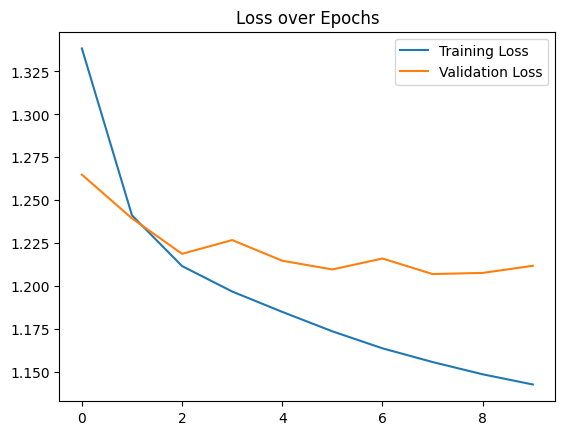

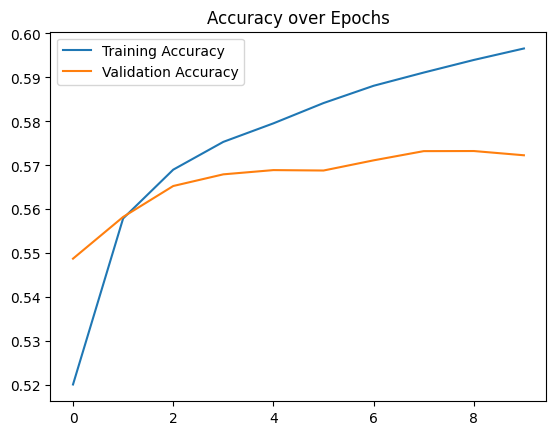

In [ ]:

print(h.history.keys()) # prints the keys of the history dictionary returned by the fit() method

import matplotlib.pyplot as plt

# plot the loss
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

# plot the accuracy
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()


The training results indicate that the model's performance is steadily improving, but the rate of improvement is gradually decreasing:  
- At epoch 1, accuracy and loss exhibit a crossover phenomenon between the training and testing datasets.  
- No significant overfitting is observed, but if further training is desired, applying dropout can be considered.

## 5. Prediction

In [ ]:
# predicted
y_pred = model.predict(X_test_padded)
# Select the class with the highest probability among the eight categories as the predicted class.
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

Convert the predicted numerical values back to the original labels

In [ ]:
y_pred_labels = label_encoder.inverse_transform(y_pred.argmax(axis=1)) # Back to the original labels
y_pred_labels[:5]

## 6. Submission

In [ ]:
#submission
sub = pd.DataFrame({
    'id': df_test['tweet_id'],
    'emotion': y_pred_labels})

In [ ]:
sub[:5]

,id,emotion
2,0x28b412,trust
4,0x2de201,anticipation
9,0x218443,joy
30,0x2939d5,joy
33,0x26289a,trust


In [ ]:
# save the result as a CSV file
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/DM2024-Lab2-Homework-main/submission.csv', index=False)


In [ ]:
# Count the occurrences of the emotions
sub["emotion"].value_counts()


,count
emotion,
joy,207694
disgust,64210
sadness,55849
trust,37049
anticipation,34413
fear,6100
anger,4977
surprise,1680


-----


I have completed the above steps and decided to improve and try new methods. Let's start with the preprocessing steps.


## 7. Preprocessing

I performed the following processing:
- Converted to lowercase.
- Removed usernames, HTML tags, and other non-alphanumeric characters.
- Removed stop words.
- Lemmatized words to their base forms.

In [5]:
import nltk
import re
from nltk.corpus import stopwords  # common words to ignore like 'and', 'the'
from nltk.stem import SnowballStemmer  # Import SnowballStemmer for stemming words


stop_words = stopwords.words("english")

stemmer = SnowballStemmer("english")
# Define a regular expression pattern to remove unwanted characters
text_remove = "@\S+|&amp;|<LH>|[^A-Za-z0-9]+"

# Define the preprocessing function
def preprocess(text, stem=True):
    """
    Preprocess the input text by:
    - Lowercasing the text
    - Removing unwanted characters such as links, user mentions, and special characters
    - Removing stopwords
    - Optionally stemming the words to reduce them to their base forms
    """
    # Remove link,user and special characters
    text = re.sub(text_remove, ' ', str(text).lower()).strip()

    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)


df_train.text = df_train.text.apply(lambda x: preprocess(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
df_train.text

,text
0,peopl post add snapchat must dehydr cuz man lh
1,see trump danger freepress around world lh lh ...
3,issa stalk tasha lh
5,thekevinallison thx best time tonight stori he...
6,still wait suppli liscus lh
...,...
1867526,happi nowond name show happi happysyfi syfi ch...
1867527,everi circumt like thank almighti jesus christ lh
1867528,current two girl walk around librari hand red ...
1867533,ah corpor life date lh use relat anachron last...


## 8. Feature Engineering (TF-IDF)

Use TF-IDF to extract the 20,000 most frequent feature words, and use nltk.word_tokenize considering that the data contains emojis

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

TFIDF200 = TfidfVectorizer(max_features=20000, tokenizer=nltk.word_tokenize, stop_words="english")

TFIDF200.fit(df_train["text"])

# Transform the training text data into TF-IDF feature vectors
X_train = TFIDF200.transform(df_train['text'])

Since data is imbalanced, I decided to use undersampling to address the issue. I chose undersampling because the dataset is very large, and applying oversampling to increase the minority class would significantly increase the total number of instances.

In [11]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Initialize RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply undersampling to the features  and labels
X_resampled, y_resampled = undersampler.fit_resample(X_train, df_train["emotion"])

# Display the class distribution after undersampling
print("Class distribution after undersampling:", Counter(y_resampled))


Class distribution after undersampling: Counter({'anger': 39867, 'anticipation': 39867, 'disgust': 39867, 'fear': 39867, 'joy': 39867, 'sadness': 39867, 'surprise': 39867, 'trust': 39867})


In [12]:
from sklearn.model_selection import train_test_split #
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled ,test_size=0.2, random_state=42)

## 9. Model Training (Naive Bayes classifier)
I chose the Naive Bayes classifier as the classification model because its advantages are simplicity and speed.

In [13]:
from sklearn.naive_bayes import MultinomialNB

# build Naive Bayes model
NB_model = MultinomialNB()

# training
NB_model = NB_model.fit(X_train, y_train)

In [14]:
from sklearn.metrics import classification_report
#prediction
y_test_pred = NB_model.predict(X_val)

print(classification_report(y_true=y_val, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.47      0.48      0.47      7989
anticipation       0.50      0.51      0.50      7916
     disgust       0.38      0.43      0.40      8014
        fear       0.49      0.55      0.52      7895
         joy       0.37      0.37      0.37      8024
     sadness       0.40      0.34      0.37      8076
    surprise       0.45      0.37      0.41      7902
       trust       0.41      0.41      0.41      7972

    accuracy                           0.43     63788
   macro avg       0.43      0.43      0.43     63788
weighted avg       0.43      0.43      0.43     63788



Although the accuracy of the validation set is not as high as LSTM, the F1-score has changed due to the sampling (there are no categories with particularly high or low values).Perhaps increasing the number of samples in the sampling process could be considered.

## 10. Prediciton

In [ ]:
X_test = TFIDF200.transform(df_test['text'])

y_test_pred = NB_model.predict(X_test)


## 11. Submission

In [16]:
result = pd.DataFrame({'id':df_test['tweet_id'],'emotion':y_test_pred})

result.set_index('id',inplace=True)

result.to_csv('submission_tfidf_bayes.csv')
result.head()

,emotion
id,
0x28b412,trust
0x2de201,anticipation
0x218443,anticipation
0x2939d5,trust
0x26289a,trust


## 12. Conclusion
- According to the Kaggle Submissions, the score of the first approach (tokenizer + LSTM) is 0.45634. Although the score is high, the training time is long, so it may be worth considering using Gated Recurrent Units (GRU), which could potentially speed up the training process.

- On the other hand, the score of the second approach (TF-IDF + Naive Bayes) is 0.30431. This is likely due to Naive Bayes' assumption of independence between features, which may limit its ability to capture complex relationships in the data, leading to lower prediction accuracy.

- I have also observed that BERT can be used to train the model, as BERT is well-suited for understanding text content. Other transformer-based models would also be suitable for this task.